# Notes

Different problems give different number of points: 2, 3 or 4.

Please, fill `STUDENT` variable with your name, so that we call collect the results automatically. Each problem contains specific validation details. We will do our best to review your assignments, but please keep in mind, that for this assignment automatic grade (between $0$ an $1$) is the primary source of ground truth.

In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [3]:
import numpy as np
import torch

In [4]:
STUDENT = "Asaf Dahan"
ASSIGNMENT = 3
TEST = False

In [5]:
if TEST:
    import solutions
    total_grade = 0
    MAX_POINTS = 11

# Basic PyTorch

### 1. ReLU activation (2 points).

ReLU is the most commonly used activation function in many deep learning application. It's defined as

$$
ReLU(x) = \max(0, x).
$$

Outpu must be of the same shape as input, and **will be tested against three random combinations of input array dimensions ($100 \leq n < 1000 $)**, while values of the input are drawn from standard normal distribution. Number of dimensions of the input will also be selected randomly and is either 1, 2 or 3.

In [6]:
def relu(arr):
    relu = torch.nn.ReLU()
    return relu(arr)

In [7]:
PROBLEM_ID = 1

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, relu)

### 2. Mean squared error (2 points).

In this problem you need to calculate MSE for a pair of tensors `y_true` and `y_pred`. MSE is defined as usual:

$$
L_{MSE} = \frac{1}{N} \sum_i \left(y_i - \hat y_i\right)^2
$$

Note, however, that `y_true` and `y_pred`may be of **different shape**. While `y_true` is always $(N,)$, `y_pred` may be $(N,1)$, $(1, N)$ or $(N,)$. Input values are drawn from standard normal distribution and **shape is selected randomly ($100 \leq n < 1000 $)**.

In [11]:
def mse(y_true, y_pred):
    errors = torch.pow(y_true - (y_pred.reshape(y_pred.size().numel())), 2)
    return torch.mean(errors).item()

In [9]:
PROBLEM_ID = 2

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, mse)

### 3. Character-level encoding (4 points).

In computations in general and in machine learning specifically letters cannot be used directly, as computers only know aboun numbers. Text data may be encoded in many different ways in natural language processing tasks.

One of the simplest ways to encode letters is to use one-hot encoded representation, with letters being "class labels". A letter is represented by a tensor of shape $(26,)$.

Then, for example, word "python" would be transformed into a tensor of shape $(6, 26)$ with all elements being $0$, except $(0, 15)\sim p,\,(1, 24)\sim y,\,(2, 19)\sim t,...$ being $1$. A phrase would be represented with 3-dimensional tensor.

In this problem you need to create a tensor, which represents a list of words `words` of length $N$. The only characters used are those from `string.ascii_lowercase`, and words are of different length $L_i$. Output must be of shape $(N, \max(L_i), 26)$.

Dimension 0 corresponds to words themselves, with `tensor[0]` being a represetation of `words[0]`. Note, that you need to use padding: although trivial in this case, you must remember, that tensor must accomodate for a longest word, thus dimension 1 is $\max(L_i)$.

Note also, that the only loop you need here is a loop over `words`, there's no need to loop over the resulting tensor.

The result will be tested against three predefined lists of word, with all words being lowercase and containing only ASCII characters.

In [10]:
def encode(words):    
    longest_word = max([len(w) for w in words])
    words_num = len(words)
    t = torch.zeros((words_num, longest_word, 26))
    
    word_idx=0
    for word in words:
        arr = torch.zeros((longest_word, 26))
        char_idx=0
        for ch in word:
            arr[char_idx, ord(ch)-97]=1.
            char_idx+=1
        t[word_idx,:] += arr
        word_idx+=1
    return t

In [11]:
PROBLEM_ID = 3

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, encode)

# Gradients

### 4. Generate gradient (1 point).

For 2-dimensional tensor `tr`, calculate a gradient of $\sum\log tr_{ij}$. Note, that you're provided with dimensions and interval, and not the `tr` inself:

- `dims` is a tuple, so that `tr.size()` equals `dims`,
- `lims` is an interval, so that elements of `tr` are integeres, uniformly sampled from `[lims[0], lims[1])` interval (note, that lims[1] is **not** included).

Result must be a tensor of the same shape as `tr` (namely, `dims`), containing gradients of the following function:

$$\sum_{ij}\log tr_{ij}.$$

and generated `tr` itself.

Result **will be tested against multiple random combinations of input tensor dimensions ($10 \leq n < 100 $) and sampling interval (`lims[0]=1`, `10 <= lims[1] < 100`)**.

**Hint**: think on how you can validate the solution yourself, given that gradient can be computed manually on paper.

In [12]:
def generate_grad(dims, lims):
    """Generate gradient of `log(x)`."""
    uni = torch.distributions.Uniform(lims[0], lims[1])
    tr = uni.sample(dims)
    tr.requires_grad=True

    # gradient calculation
    f = torch.log(tr).sum()
    f.backward()
    return tr.grad, tr

In [13]:
PROBLEM_ID = 4

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, generate_grad)

### 5. Find a minimum (2 points, manually graded).

Consider the following scalar function:

$$
f(x) = ax^2 + bx + c
$$

Given the $a,b,c$, find $x$, which minimizes $f(x)$. Note this:

- $a,b,c$ are fixed, and generated in such a way, that minimum always exists ($f(x)$ is convex),
- $x$ is a scalar value, i.e. 0-dimensional tensor.

**Hint:** stop for a second to think about which tensor must contain `requires_grad` and on which scalar should `.backward()` be called.

In [14]:
def generate_coeffs():
    a = torch.rand(size=()) * 10
    b = -10 + torch.rand(size=()) * 10
    c = -10 + torch.rand(size=()) * 10
    return a, b, c

def func(x, a, b, c):
    return x.pow(2) * a + x * b + c

In [19]:
EPOCHS = 20
LR = 1e-1
STARTING_VAL = 0. # Consider choosing different starting values for x to speed-up the optimization

# Initialize x, a, b, c
x = torch.tensor([STARTING_VAL], requires_grad=True)
a, b, c = generate_coeffs()

# Collect f(x) values during training for visuzalition later on
f_vals = []

print(f"Initial values: A[{a}], B[{b}], C [{c}]\n")

for i in range(EPOCHS):
    f = func(x, a, b, c)
    f.backward()
    fval = f.item()
    f_vals.append(fval)

    loss = x.grad.item()
    with torch.no_grad():
        x.sub_(LR * loss)
    x.grad.zero_()
    print(f"Iteration - {i} Function Value - {fval} X Value - {x.item()}")


Initial values: A[2.818504571914673], B[-9.663649559020996], C [-3.1980743408203125]

Iteration - 0 Function Value - -3.1980743408203125 X Value - 0.9663649797439575
Iteration - 1 Function Value - -9.904594421386719 X Value - 1.3879890441894531
Iteration - 2 Function Value - -11.18122673034668 X Value - 1.5719432830810547
Iteration - 3 Function Value - -11.42424201965332 X Value - 1.6522023677825928
Iteration - 4 Function Value - -11.470502853393555 X Value - 1.6872193813323975
Iteration - 5 Function Value - -11.479308128356934 X Value - 1.7024972438812256
Iteration - 6 Function Value - -11.480984687805176 X Value - 1.709162950515747
Iteration - 7 Function Value - -11.481304168701172 X Value - 1.712071180343628
Iteration - 8 Function Value - -11.481363296508789 X Value - 1.7133400440216064
Iteration - 9 Function Value - -11.481375694274902 X Value - 1.7138936519622803
Iteration - 10 Function Value - -11.481378555297852 X Value - 1.7141351699829102
Iteration - 11 Function Value - -11.48

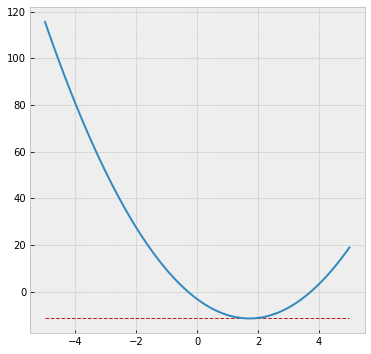

In [20]:
if f_vals:
    grid = np.linspace(-5, 5, 100)
    plt.plot(grid, np.square(grid) * a.item() + grid * b.item() + c.item())
    plt.hlines(f_vals[-1], -5, 5, "firebrick", "--", linewidth=1)

In [21]:
PROBLEM_ID = 5
GRADE = 0

if TEST:
    total_grade += GRADE

In [22]:
if TEST:
    print(f"{STUDENT}: {int(100 * total_grade / MAX_POINTS)}")